<a href="https://colab.research.google.com/github/feist000/Study/blob/master/Crawling/NsearchStock_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 네이버 데이터랩의 검색어 트렌드의 주가 영향력 분석
* 검색어 트렌드 분석을 통한 검색어 증가에 따른 주가 영향 분석
* 마케팅 효과에따른 검색어 증가량 분석
* 마케팅 수명관리
* 경쟁사 마케팅 파급효과 분석


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
nid = "tjM9TlFAktHddGMdwPyd"
nkey = "I4rRD_LsrS"

In [ ]:

import json ###########################
import os
import sys
import urllib.request


In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fname=fm.FontProperties(fname='malgun.ttf').get_name()
mpl.rc('font',family=fname)
import matplotlib.gridspec as gridspec


In [ ]:
def makeQry(keywords=[],sday='2019-01-01',eday='2020-08-30',tunit='date'):
    res=[]
    for words in keywords:
        dict={'groupName':words[0],'keywords':words}
        res.append(dict)
    rdict={"startDate":sday,
    "endDate":eday,
    "timeUnit":tunit,
    "keywordGroups":res
          }
    return json.dumps(rdict,ensure_ascii = False )


In [ ]:
def Mynsearch(keywords=[],sday='2019-01-01',eday='2020-08-30',tunit='date'):    
    client_id = nid ##########################
    client_secret = nkey ###########################
    url = "https://openapi.naver.com/v1/datalab/search";
    
    body=makeQry(keywords,sday,eday,tunit)
    
    request = urllib.request.Request(url)
    request.add_header("X-Naver-Client-Id",client_id)
    request.add_header("X-Naver-Client-Secret",client_secret)
    request.add_header("Content-Type","application/json")
    response = urllib.request.urlopen(request, data=body.encode("utf-8"))
    rescode = response.getcode()
    if(rescode==200):
        response_body = response.read()
        res=response_body.decode('utf-8')
        #print(res)
    else:
        res="error"
        print("Error Code:" + rescode)
    return res

In [ ]:

def MyDataLab(keywords=[],sday='2019-01-01',eday='2020-08-30',tunit='date'):
    # 네이버 데이터랩 서치
    res=Mynsearch(keywords,sday,eday,tunit)
    #데이터 추출을 위한 json
    jdata=json.loads(res)
            #print(len(jdata['results']))
    i=0;
    #테이블 머지를 위한 기초테이블
    maindf=pd.DataFrame()
    # 키워드별로 컬럼명 지정
    for words in keywords:
        pdata=jdata['results'][i]['data']
        i+=1
        df=pd.DataFrame.from_dict(pdata)
        df.columns=["period",words[0].strip()]
        df1=df.set_index("period")
        maindf=pd.merge(maindf,df1,how="outer",left_index=True,right_index=True)
    return maindf


               극한직업      사바하      걸캅스    나쁜녀석들      백두산
period                                                 
2019-01-01  0.51273  0.03758  0.01178  0.15669  0.14547
2019-01-02  0.59014  0.03655  0.01355  0.14220  0.11658
2019-01-03  0.57528  0.02870  0.00981  0.11350  0.10892
2019-01-04  5.09767  0.02758  0.01552  0.12453  0.10172
2019-01-05  1.13232  0.03300  0.01299  0.14248  0.08695


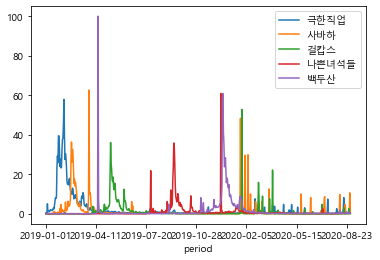

In [ ]:
keywords=[
['극한직업'],
['사바하'],
['걸캅스'],
['나쁜녀석들'],
['백두산'],
#['기생충','봉준호','짜파구리'],
]
mdf=MyDataLab(keywords,'2019-01-01','2020-08-30','date')
print(mdf.head())
mdf.plot()
plt.show()

In [ ]:
import sqlite3
dbname='NaverStocks.db'
def selData(whr=' where SIDX=0'):
    with sqlite3.connect(dbname) as conn:
        cur=conn.cursor()
        sql='select SDAY,OPENP,HIGHP,LOWP,CLOSEP,VOL from StockDay '+whr
        cur.execute(sql)
        rows=cur.fetchall()
        cur.close()
    return rows

In [ ]:
def MyDBLab(keywords=[],sday='2019-01-01',eday='2020-08-30',tunit='date',scode='035760'):
    mdf=MyDataLab(keywords,sday,eday,tunit)
    sdaycode=sday.replace('-','')
    edaycode=eday.replace('-','')
    whsrc='where SDAY>={0} and SDAY<={1} and SCODE="{2}" order by SDAY  asc'
    whr=whsrc.format(sdaycode,edaycode,scode)
    res=selData(whr)
    cols=['SDAY','OPENP','HIGHP','LOWP','CLOSEP','VOL']
    dfsrc=pd.DataFrame(data=res,columns=cols)
    dfsrc['period']=[str(p)[:4]+"-"+str(p)[4:-2]+"-"+str(p)[-2:] for p in dfsrc['SDAY']]
    dfstock=dfsrc.set_index('period')
    df=pd.merge(dfstock,mdf,how="outer",left_index=True, right_index=True)
    alldf=df.interpolate() ############# 선형보간
    return alldf

In [ ]:
keywords=[
['극한직업'],
#['사바하'],
#['걸캅스'],
#['나쁜녀석들'],
#['백두산'],
#['기생충','봉준호','짜파구리'],
]
alldf=MyDBLab(keywords,'2019-01-15','2019-02-15','date','035760')
alldf.head(10)

,SDAY,OPENP,HIGHP,LOWP,CLOSEP,VOL,극한직업
period,,,,,,,
2019-01-15,20190115.0,211400.000000,212900.000000,208400.0,212900.0,54176.000000,4.04935
2019-01-16,20190116.0,213000.000000,217600.000000,211200.0,216000.0,82763.000000,5.14039
2019-01-17,20190117.0,214800.000000,215300.000000,205800.0,209100.0,66824.000000,4.38706
2019-01-18,20190118.0,208500.000000,208500.000000,202500.0,206500.0,74195.000000,7.29230
2019-01-19,20190119.0,207633.333333,208366.666667,203100.0,206200.0,66475.333333,10.99330
2019-01-20,20190120.0,206766.666667,208233.333333,203700.0,205900.0,58755.666667,14.18881
2019-01-21,20190121.0,205900.000000,208100.000000,204300.0,205600.0,51036.000000,13.45806
2019-01-22,20190122.0,205500.000000,206100.000000,203500.0,206000.0,33588.000000,15.23499
2019-01-23,20190123.0,205500.000000,205900.000000,203400.0,205800.0,48354.000000,40.86066


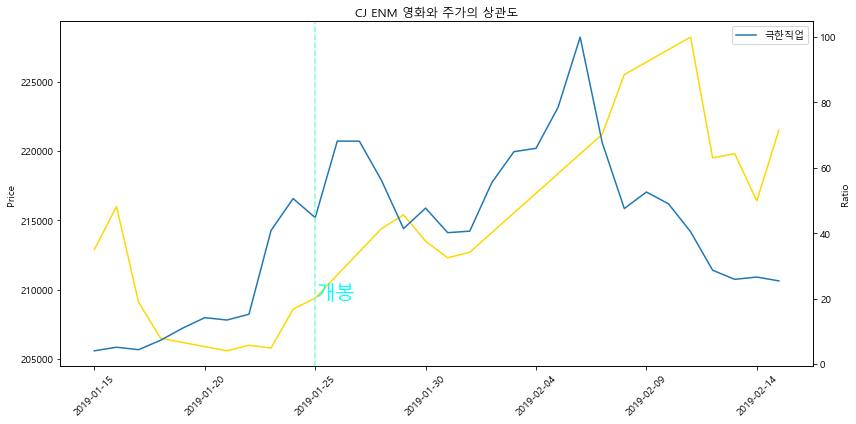

In [ ]:
xtic=np.arange(0,len(alldf.index),step=5)
xdays=[alldf.index[i] for i in xtic]
setdf=alldf[keywords[0]]#,'사바하','걸캅스','나쁜녀석들','백두산'
#setdf.head()
font = {'family': fname,
        'color':  'aqua',
        'weight': 'normal',
        'size': 20,
        }
# x 축을 공유하고 y축을 2중 사용
plt.rcParams["figure.figsize"]=(12,6)
fig, ax1=plt.subplots()
plt.xticks(xtic,xdays,rotation=45)

ax1.plot(alldf['CLOSEP'] ,color='gold')
ax1.set_ylabel("Price")
ax2=ax1.twinx()
ax2.set_ylabel("Ratio")
setdf.plot(ax=ax2)
pos=10
plt.axvline(pos,color='aquamarine',linestyle="--")
plt.text(pos,20,"개봉",fontdict=font)
plt.title("CJ ENM 영화와 주가의 상관도")
plt.legend()
fig.tight_layout()
plt.show()

In [ ]:
def PltDBLab(alldf,keywords,ptitle="CJ ENM 영화와 주가의 상관도",xstep=10):
    xtic=np.arange(0,len(alldf.index),step=xstep)
    xdays=[alldf.index[i] for i in xtic]
    setdf=alldf[keywords[0]]#,'사바하','걸캅스','나쁜녀석들','백두산'
    #setdf.head()
    font = {'family': fname,
            'color':  'aqua',
            'weight': 'normal',
            'size': 20,
            }
    # x 축을 공유하고 y축을 2중 사용
    plt.rcParams["figure.figsize"]=(12,6)
    fig, ax1=plt.subplots()
    plt.xticks(xtic,xdays,rotation=45)

    ax1.plot(alldf['CLOSEP'] ,color='gold')
    ax1.set_ylabel("Price")
    ax2=ax1.twinx()
    ax2.set_ylabel("Ratio")
    setdf.plot(ax=ax2)
    pos=10
    plt.axvline(pos,color='aquamarine',linestyle="--")
    plt.text(pos,20,"개봉",fontdict=font)
    plt.title(ptitle)
    plt.legend()
    fig.tight_layout()
    plt.show()

In [ ]:
alldf[['CLOSEP','극한직업']].corr()

,CLOSEP,극한직업
CLOSEP,1.000000,0.390641
극한직업,0.390641,1.000000
